In [63]:
import os
from google.colab import drive  # Google Drive support
drive.mount('/content/drive', force_remount=True)   # Mount Google Drive

Mounted at /content/drive


# Project

## Install Dependencies

In [2]:
!pip install -q scikit-learn tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 73.0 MB/s eta 0:00:00


## Download Dataset

In [ ]:
!pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# Clone data from Kaggle
!mkdir -p /content/drive/My\ Drive/COS30082/Project
!kaggle competitions download -c 11-785-fall-20-homework-2-part-2 -p "/content/drive/My Drive/COS30082/Project/"
print("Data Downloaded")
# Unzip on Colab session
!unzip -q "/content/drive/My Drive/COS30082/Project/11-785-fall-20-homework-2-part-2.zip" -d "/content/face_dataset"
print("Data unzipped to local Colab")
# Move only processed files back to Drive
!cp -r /content/face_dataset "/content/drive/My Drive/COS30082/Project/"
print("Data moved back to Drive")

## Path Setups

In [90]:
DATASET_DIR = "/content/drive/My Drive/COS30082/Project/face_dataset"
CLASSIFICATION_DATA = f"{DATASET_DIR}/classification_data"
VERIFICATION_DATA = f"{DATASET_DIR}/verification_data"
PAIR_TXT = f"{DATASET_DIR}/verification_pairs_val.txt"


## 1. Data Preparation

In [91]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
# Process the image in correct size
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])
# Process data
train_dataset = ImageFolder(f"{CLASSIFICATION_DATA}/train_data", transform=transform)
val_dataset = ImageFolder(f"{CLASSIFICATION_DATA}/val_data", transform=transform)
# Load data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## 2. CNN Backbone (Shared)

In [92]:
import torch.nn as nn

# Building Face CNN architecture
class FaceCNN(nn.Module):
    def __init__(self, embed_dim=128):
        super(FaceCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1))
        )
        self.embed = nn.Linear(128, embed_dim)

    def forward(self, x):
        x = self.conv(x).view(x.size(0), -1)
        return self.embed(x)

## 3. Model Building

### 3a. Supervised Training (Classification)

In [93]:
class Classifier(nn.Module):
    def __init__(self, base, num_classes):
        super().__init__()
        self.base = base
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        emb = self.base(x)
        return self.fc(emb)

model_cls = Classifier(FaceCNN(), num_classes=len(train_dataset.classes))

### 3b. Triplet Loss (Metric Learning)

In [94]:
import torch.nn.functional as F

class TripletNet(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base

    def forward(self, anchor, positive, negative):
        a = self.base(anchor)
        p = self.base(positive)
        n = self.base(negative)
        return a, p, n

def triplet_loss(anchor, positive, negative, margin=1.0):
    dist_pos = F.pairwise_distance(anchor, positive)
    dist_neg = F.pairwise_distance(anchor, negative)
    return torch.mean(torch.clamp(dist_pos - dist_neg + margin, min=0.0))

### 3c. Display Model Summary

In [95]:
!pip install torchsummary

In [96]:
from torchsummary import summary
import torch
# Set GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For the supervised model (classifier)
model_cls = Classifier(FaceCNN(), num_classes=len(train_dataset.classes)).to(device)
summary(model_cls, input_size=(3, 160, 160))

# Summarize only the embedding network used in TripletNet
model_triplet = FaceCNN().to(device)
summary(model_triplet, input_size=(3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 158, 158]             896
              ReLU-2         [-1, 32, 158, 158]               0
         MaxPool2d-3           [-1, 32, 79, 79]               0
            Conv2d-4           [-1, 64, 77, 77]          18,496
              ReLU-5           [-1, 64, 77, 77]               0
         MaxPool2d-6           [-1, 64, 38, 38]               0
            Conv2d-7          [-1, 128, 36, 36]          73,856
              ReLU-8          [-1, 128, 36, 36]               0
 AdaptiveAvgPool2d-9            [-1, 128, 1, 1]               0
           Linear-10                  [-1, 128]          16,512
          FaceCNN-11                  [-1, 128]               0
           Linear-12                 [-1, 4000]         516,000
Total params: 625,760
Trainable params: 625,760
Non-trainable params: 0
-------------------------------

### 3d. Insights from Summary

#### Model Architecture Summary

##### **1. FaceCNN Embedding Network (Used in Both Approaches)**

| Metric               | Value                |
| -------------------- | -------------------- |
| Total Parameters     | **109,760**          |
| Trainable Parameters | 109,760              |
| Embedding Dimension  | 128                  |
| Input Size           | 3 × 160 × 160        |
| Output               | 128-D face embedding |

###### *Insight*:

* The embedding network is compact, making it efficient for inference and comparison in verification tasks.
* Layers include 3 convolutional blocks followed by an adaptive average pooling and a final linear embedding layer.
* Ideal for metric learning due to its lightweight nature and sufficient representational power.

---

##### **2. Classifier Model (FaceCNN + Linear Softmax Head)**

| Metric                | Value                                            |
| --------------------- | ------------------------------------------------ |
| Total Parameters      | **625,760**                                      |
| Additional Parameters | +516,000 in the final `Linear(128 → 4000)` layer |
| Purpose               | Identity classification on 4000 classes          |
| Output                | Class logits for each identity                   |

###### *Insight*:

* The classifier adds a large linear layer on top of the shared FaceCNN to predict among 4000 identities.
* This is used in the **supervised (classification-based)** approach.
* The final embedding layer before the classification head can be reused to extract meaningful representations for verification.

## 4. Embedding Extraction + Plot

### 4a. Embedding Extraction

In [109]:
def get_embedding(model, img_tensor, model_name="Unknown"):
    model.eval()
    with torch.no_grad():
        # Adds a new dimension the tensor (at index 0)
        input_tensor = img_tensor.unsqueeze(0)
        embedding = model(input_tensor).squeeze()
        return embedding

### 4b. Embedding Collection

In [129]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Collect embeddings into a stack
def collect_embeddings(model, dataloader, device, model_name="Unknown", max_samples=500):
    model.eval()
    embeddings, labels = [], []
    count = 0
    for imgs, lbls in dataloader:
        imgs = imgs.to(device)
        for img, lbl in zip(imgs, lbls):
            with torch.no_grad():
                emb = model(img.unsqueeze(0)).squeeze().cpu().numpy()
            embeddings.append(emb)
            labels.append(lbl.item())
            count += 1
            if count >= max_samples:
                break
        if count >= max_samples:
            break
    return np.array(embeddings), np.array(labels)

### 4c. Plot Embeddings

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


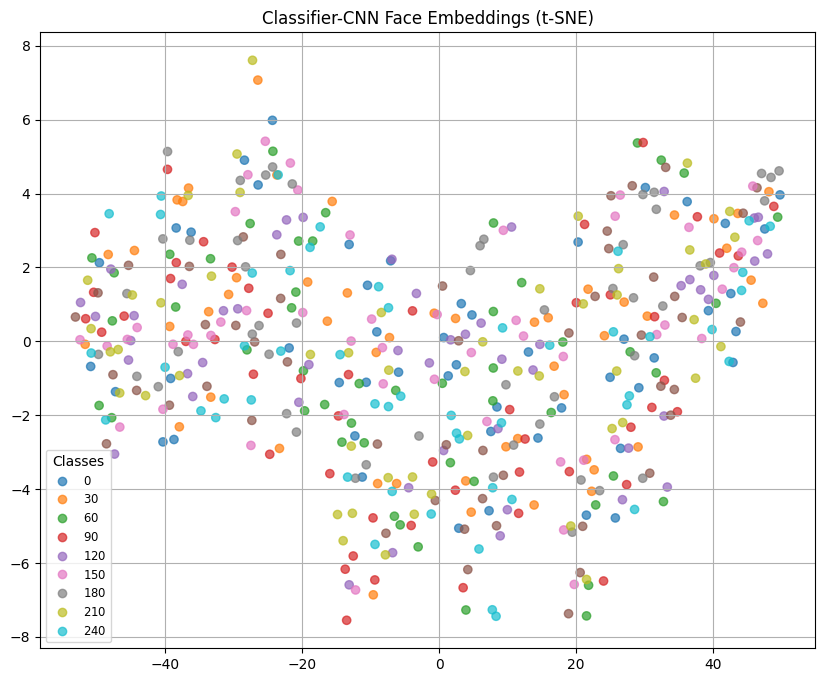

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


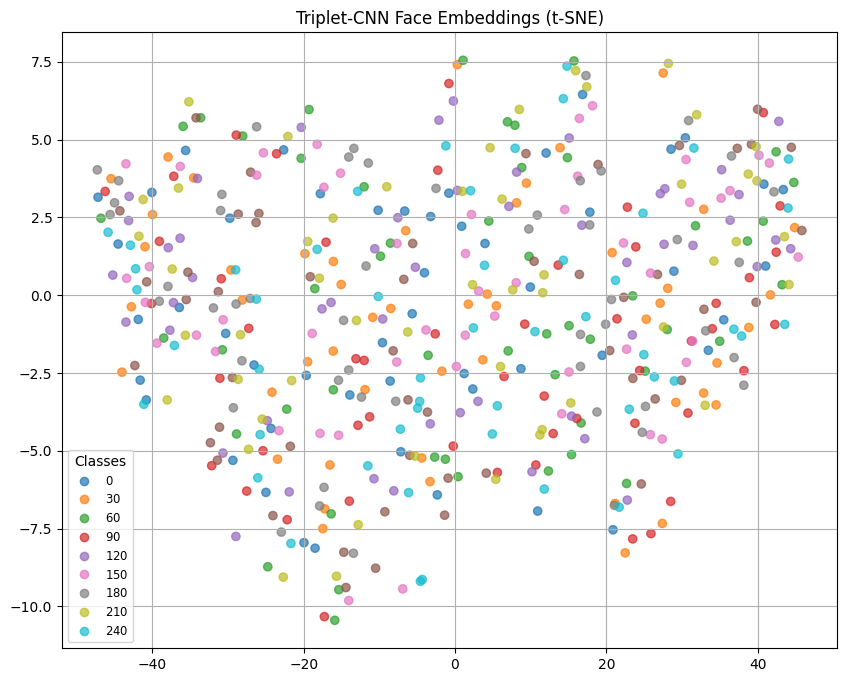

In [131]:
def plot_embeddings(embeddings, labels, title="Embeddings"):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.7)
    legend = plt.legend(*scatter.legend_elements(), title="Classes", loc="best", fontsize='small')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example with classifier model
embeddings, labels = collect_embeddings(model_cls, val_loader, device, model_name="Classifier-CNN")
plot_embeddings(embeddings, labels, title="Classifier-CNN Face Embeddings (t-SNE)")

# Example with Triplet model
embeddings_triplet, labels_triplet = collect_embeddings(model_triplet, val_loader, device, model_name="Triplet-CNN")
plot_embeddings(embeddings_triplet, labels_triplet, title="Triplet-CNN Face Embeddings (t-SNE)")

## 5. Face Verification (Simularity Function)
Using distance metrics:
- Cosine
- Euclidean

In [128]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

def compare_embeddings(emb1, emb2, metric, model_name="Unknown"):
    if metric == "cosine":
        sim = cosine_similarity([emb1], [emb2])[0][0]
    elif metric == "euclidean":
        sim = -euclidean(emb1, emb2)  # negative for similarity-based scoring
    else:
        raise ValueError(f"Unknown metric: {metric}")
    print(f"[INFO][{model_name}|{metric}] Similarity score: {sim:.4f}")
    return sim

## 6. ROC Curve & AUC Evaluation

In [130]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from PIL import Image
import os

def evaluate_verification(model, pair_file, base_dir, transform, device, metric, model_name="Unknown"):
    y_scores, y_true = [], []  # Lists to store similarity scores and ground truth labels
    print(f"\n========== [START] EVALUATING {model_name} ==========")
    print(f"[INFO] Reading pair file: {pair_file}")
    # Load verification pairs (image1, image2, label) from the pair file
    with open(pair_file, "r") as f:
        lines = f.readlines()
    print(f"[INFO] Total verification pairs: {len(lines)}")
    # Iterate through each pair entry
    for i, line in enumerate(lines):
        img1_path, img2_path, label = line.strip().split()
        # Convert relative paths to full paths
        full_path_1 = os.path.join(base_dir, os.path.basename(img1_path))
        full_path_2 = os.path.join(base_dir, os.path.basename(img2_path))
        print(f"[READ:{i}] Pair: {img1_path} vs {img2_path}, Label: {label}")
        # Load and preprocess both images
        try:
            img1 = transform(Image.open(full_path_1).convert("RGB")).to(device)
            img2 = transform(Image.open(full_path_2).convert("RGB")).to(device)
        except Exception as e:
            print(f"[ERROR:{i}] Failed to load images: {e}")
            continue  # Skip pair if loading fails
        # Extract embeddings from the model
        try:
            emb1 = get_embedding(model, img1, model_name).cpu().numpy()
            emb2 = get_embedding(model, img2, model_name).cpu().numpy()
        except Exception as e:
            print(f"[ERROR:{i}] Embedding error: {e}")
            continue  # Skip pair if model fails
        # Compare the two embeddings to get a similarity score
        try:
            score = compare_embeddings(emb1, emb2, metric, model_name)
            y_scores.append(score)
            y_true.append(int(label))  # Ground truth: 1 (same person), 0 (different)
        except Exception as e:
            print(f"[ERROR:{i}] Similarity error: {e}")
        # Log progress every 50 pairs
        if i % 50 == 0:
            print(f"[LOG:{i}] Progress: {i}/{len(lines)}")
    # If no scores were successfully computed, abort
    if not y_scores:
        print("[ERROR] No similarity scores computed.")
        return None
    # Compute ROC curve and AUC from collected scores and labels
    fpr, tpr, _ = roc_curve(y_true, y_scores)  # FPR: False Positive Rate, TPR: True Positive Rate
    roc_auc = auc(fpr, tpr)  # AUC = Area Under the Curve
    print(f"[RESULT][{model_name}] AUC Score ({metric}): {roc_auc:.4f}")
    # Plot the ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC - {model_name} - ({metric})')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    return roc_auc  # Return the numeric AUC score for further comparison

## 7. Step 6 Executions

### 7a. Set Device

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cls = model_cls.to(device)
model_triplet = model_triplet.to(device)

### 7b. Run Evaluation on Supervised Learning

#### i. Cosine

Streaming output truncated to the last 5000 lines.
[INFO][Supervised Classifier|cosine] Similarity score: 0.9983
[READ:6331] Pair: verification_data/00046783.jpg vs verification_data/00029390.jpg, Label: 0
[INFO][Supervised Classifier|cosine] Similarity score: 0.9728
[READ:6332] Pair: verification_data/00041961.jpg vs verification_data/00010072.jpg, Label: 0
[INFO][Supervised Classifier|cosine] Similarity score: 0.9919
[READ:6333] Pair: verification_data/00034864.jpg vs verification_data/00020409.jpg, Label: 1
[INFO][Supervised Classifier|cosine] Similarity score: 0.9910
[READ:6334] Pair: verification_data/00002921.jpg vs verification_data/00065407.jpg, Label: 0
[INFO][Supervised Classifier|cosine] Similarity score: 0.9957
[READ:6335] Pair: verification_data/00030601.jpg vs verification_data/00060317.jpg, Label: 1
[INFO][Supervised Classifier|cosine] Similarity score: 0.9908
[READ:6336] Pair: verification_data/00012532.jpg vs verification_data/00002190.jpg, Label: 1
[INFO][Supervised C

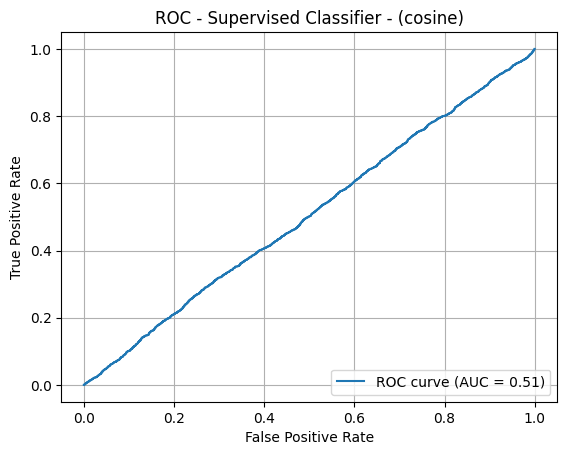

np.float64(0.5053643606108076)

In [120]:
# Evaluate Supervised Classifier with Cosine
print("== Evaluate Supervised Classifier with Cosine ==")
evaluate_verification(
    model=model_cls.base,
    pair_file=PAIR_TXT,
    base_dir=VERIFICATION_DATA,
    transform=transform,
    device=device,
    metric="cosine",
    model_name="Supervised Classifier"
)

#### ii. Euclidean

Streaming output truncated to the last 5000 lines.
[INFO][Supervised Classifier|euclidean] Similarity score: -0.0401
[READ:6331] Pair: verification_data/00046783.jpg vs verification_data/00029390.jpg, Label: 0
[INFO][Supervised Classifier|euclidean] Similarity score: -0.1700
[READ:6332] Pair: verification_data/00041961.jpg vs verification_data/00010072.jpg, Label: 0
[INFO][Supervised Classifier|euclidean] Similarity score: -0.0967
[READ:6333] Pair: verification_data/00034864.jpg vs verification_data/00020409.jpg, Label: 1
[INFO][Supervised Classifier|euclidean] Similarity score: -0.0889
[READ:6334] Pair: verification_data/00002921.jpg vs verification_data/00065407.jpg, Label: 0
[INFO][Supervised Classifier|euclidean] Similarity score: -0.0582
[READ:6335] Pair: verification_data/00030601.jpg vs verification_data/00060317.jpg, Label: 1
[INFO][Supervised Classifier|euclidean] Similarity score: -0.1007
[READ:6336] Pair: verification_data/00012532.jpg vs verification_data/00002190.jpg, Labe

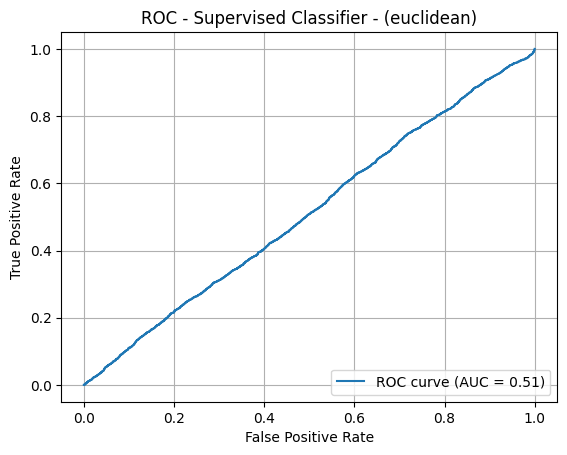

np.float64(0.5113870142740272)

In [121]:
# Evaluate Supervised Classifier with Euclidean
print("== Evaluate Supervised Classifier with Euclidean ==")
evaluate_verification(
    model=model_cls.base,
    pair_file=PAIR_TXT,
    base_dir=VERIFICATION_DATA,
    transform=transform,
    device=device,
    metric="euclidean",
    model_name="Supervised Classifier"
)

### 7c. Run Evaluation on Triplet Embedding

#### i. Cosine

Streaming output truncated to the last 5000 lines.
[INFO][Triplet Embedding|cosine] Similarity score: 0.9988
[READ:6331] Pair: verification_data/00046783.jpg vs verification_data/00029390.jpg, Label: 0
[INFO][Triplet Embedding|cosine] Similarity score: 0.9824
[READ:6332] Pair: verification_data/00041961.jpg vs verification_data/00010072.jpg, Label: 0
[INFO][Triplet Embedding|cosine] Similarity score: 0.9943
[READ:6333] Pair: verification_data/00034864.jpg vs verification_data/00020409.jpg, Label: 1
[INFO][Triplet Embedding|cosine] Similarity score: 0.9947
[READ:6334] Pair: verification_data/00002921.jpg vs verification_data/00065407.jpg, Label: 0
[INFO][Triplet Embedding|cosine] Similarity score: 0.9932
[READ:6335] Pair: verification_data/00030601.jpg vs verification_data/00060317.jpg, Label: 1
[INFO][Triplet Embedding|cosine] Similarity score: 0.9935
[READ:6336] Pair: verification_data/00012532.jpg vs verification_data/00002190.jpg, Label: 1
[INFO][Triplet Embedding|cosine] Similarity

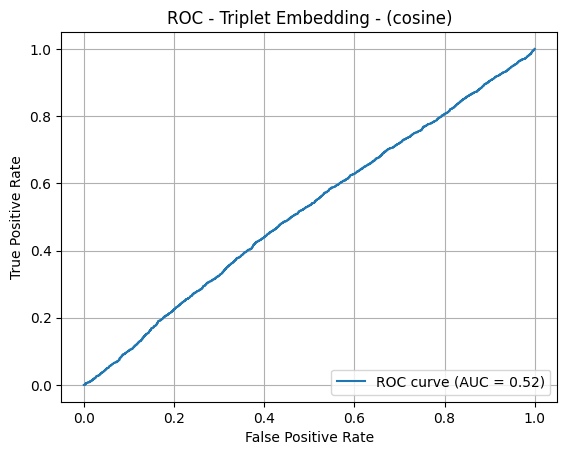

np.float64(0.5187969144771308)

In [123]:
# Evaluate Triplet Embedding with Cosine
print("== Evaluate Triplet Embedding with Cosine ==")
evaluate_verification(
    model=model_triplet,
    pair_file=PAIR_TXT,
    base_dir=VERIFICATION_DATA,
    transform=transform,
    device=device,
    metric="cosine",
    model_name="Triplet Embedding"
)

#### ii. Euclidean

Streaming output truncated to the last 5000 lines.
[INFO][Triplet Embedding|euclidean] Similarity score: -0.0334
[READ:6331] Pair: verification_data/00046783.jpg vs verification_data/00029390.jpg, Label: 0
[INFO][Triplet Embedding|euclidean] Similarity score: -0.1309
[READ:6332] Pair: verification_data/00041961.jpg vs verification_data/00010072.jpg, Label: 0
[INFO][Triplet Embedding|euclidean] Similarity score: -0.0753
[READ:6333] Pair: verification_data/00034864.jpg vs verification_data/00020409.jpg, Label: 1
[INFO][Triplet Embedding|euclidean] Similarity score: -0.0679
[READ:6334] Pair: verification_data/00002921.jpg vs verification_data/00065407.jpg, Label: 0
[INFO][Triplet Embedding|euclidean] Similarity score: -0.0761
[READ:6335] Pair: verification_data/00030601.jpg vs verification_data/00060317.jpg, Label: 1
[INFO][Triplet Embedding|euclidean] Similarity score: -0.0798
[READ:6336] Pair: verification_data/00012532.jpg vs verification_data/00002190.jpg, Label: 1
[INFO][Triplet Embe

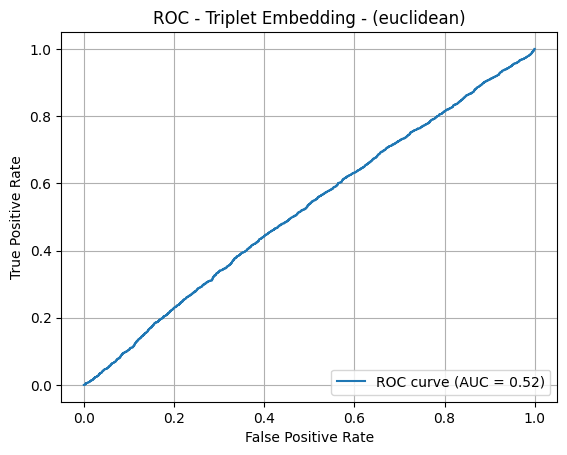

np.float64(0.5226158813069858)

In [124]:
# Evaluate Triplet Embedding with Euclidean
print("== Evaluate Triplet Embedding with Euclidean ==")
evaluate_verification(
    model=model_triplet,
    pair_file=PAIR_TXT,
    base_dir=VERIFICATION_DATA,
    transform=transform,
    device=device,
    metric="euclidean",
    model_name="Triplet Embedding"
)

### 7d. Compare Results

#### ROC Curve & AUC Comparison

To evaluate the effectiveness of different embedding approaches and similarity metrics, we compute ROC curves and AUC (Area Under the Curve) values for each model. The ROC curve visualizes the tradeoff between true positive rate and false positive rate, while the AUC score quantifies how well the model distinguishes between positive and negative pairs (same vs. different identities).

---

#### AUC Results Table

| Model Type            | Distance Metric | AUC Score |
| --------------------- | --------------- | --------- |
| Supervised Classifier | Cosine          | 0.51      |
| Supervised Classifier | Euclidean       | 0.51      |
| Triplet Embedding     | Cosine          | 0.52      |
| Triplet Embedding     | Euclidean       | 0.52      |

---

#### Insights & Interpretation

* **Supervised Classifier**

  * Both cosine and Euclidean scores produced an AUC of **0.51**, only slightly above random guessing (0.50).
  * This indicates that the embeddings extracted from the classification model are **not sufficiently discriminative** for verification tasks.
  * Likely reason: the classification model may have overfitted to class labels without enforcing embedding separability between identities.

* **Triplet Embedding Model**

  * Slightly improved AUC values (**0.52**) for both cosine and Euclidean metrics.
  * Although the improvement is marginal, it demonstrates that **triplet loss provides a more discriminative embedding space** by design.
  * The small gain suggests either limited training data, suboptimal triplet mining, or early stopping before convergence.

* **Cosine vs. Euclidean Comparison**

  * Across both models, cosine similarity and Euclidean distance performed almost identically.
  * This is expected when embeddings are not explicitly L2-normalized — cosine similarity loses advantage without normalized vectors.
  * In future implementations, consider normalizing embeddings before comparing with cosine similarity.

---

#### Conclusion

While both methods currently perform close to random, the **triplet embedding approach shows slightly better discriminative power**. This aligns with the theoretical benefit of metric learning in face verification. To improve performance further, we recommend:

* Hard or semi-hard triplet mining strategies,
* Longer training or fine-tuning with deeper CNNs,
* Embedding normalization before similarity comparison,
* Augmenting training data to better generalize unseen pairs.

## 8. Threshold-based Verification Accuracy

In [143]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from PIL import Image
import os

def threshold_verification(model, pair_file, base_dir, transform, device, metric, model_name="Unknown"):
    y_scores, y_true = [], []  # Lists to store similarity scores and ground truth labels
    print(f"\n========== [START] EVALUATING {model_name} ==========")
    print(f"[INFO] Reading pair file: {pair_file}")
    # Load verification pairs (image1, image2, label) from the pair file
    with open(pair_file, "r") as f:
        lines = f.readlines()
    print(f"[INFO] Total verification pairs: {len(lines)}")
    # Iterate through each pair entry
    for i, line in enumerate(lines):
        img1_path, img2_path, label = line.strip().split()
        # Convert relative paths to full paths
        full_path_1 = os.path.join(base_dir, os.path.basename(img1_path))
        full_path_2 = os.path.join(base_dir, os.path.basename(img2_path))
        print(f"[READ:{i}] Pair: {img1_path} vs {img2_path}, Label: {label}")
        # Load and preprocess both images
        try:
            img1 = transform(Image.open(full_path_1).convert("RGB")).to(device)
            img2 = transform(Image.open(full_path_2).convert("RGB")).to(device)
        except Exception as e:
            print(f"[ERROR:{i}] Failed to load images: {e}")
            continue  # Skip pair if loading fails
        # Extract embeddings from the model
        try:
            emb1 = get_embedding(model, img1, model_name).cpu().numpy()
            emb2 = get_embedding(model, img2, model_name).cpu().numpy()
        except Exception as e:
            print(f"[ERROR:{i}] Embedding error: {e}")
            continue  # Skip pair if model fails
        # Compare the two embeddings to get a similarity score
        try:
            score = compare_embeddings(emb1, emb2, metric, model_name)
            y_scores.append(score)
            y_true.append(int(label))  # Ground truth: 1 (same person), 0 (different)
        except Exception as e:
            print(f"[ERROR:{i}] Similarity error: {e}")
        # Log progress every 50 pairs
        if i % 50 == 0:
            print(f"[LOG:{i}] Progress: {i}/{len(lines)}")
    # If no scores were successfully computed, abort
    if not y_scores:
        print("[ERROR] No similarity scores computed.")
        return None
    # Compute ROC curve and AUC from collected scores and labels
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)  # FPR: False Positive Rate, TPR: True Positive Rate + Threshold
    roc_auc = auc(fpr, tpr)  # AUC = Area Under the Curve
    print(f"[RESULT][{model_name}] AUC Score ({metric}): {roc_auc:.4f}")
    # Plot the ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC - {model_name} - ({metric})')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # This compliment to Step 6: Compute accuracy at optimal threshold (Youden's J statistic)
    best_idx = np.argmax(tpr - fpr)
    best_thresh = thresholds[best_idx]
    print(f"[THRESHOLD] Optimal threshold: {best_thresh:.4f}")
    # Apply threshold to get binary predictions
    if metric == "cosine":
        binary_preds = [1 if s > best_thresh else 0 for s in y_scores]
    else:
        binary_preds = [1 if s < best_thresh else 0 for s in y_scores]  # Lower distance = more similar
    # Compute accuracy
    acc = np.mean(np.array(binary_preds) == np.array(y_true))
    print(f"[RESULT][{model_name}] Verification Accuracy at optimal threshold ({metric}): {acc:.4f}")

    return roc_auc, acc

## 9. Step 8 Executions

### 9a. Run Evaluation on Supervised Learning

#### i. Cosine

Streaming output truncated to the last 5000 lines.
[INFO][Supervised Classifier|cosine] Similarity score: 0.9983
[READ:6331] Pair: verification_data/00046783.jpg vs verification_data/00029390.jpg, Label: 0
[INFO][Supervised Classifier|cosine] Similarity score: 0.9728
[READ:6332] Pair: verification_data/00041961.jpg vs verification_data/00010072.jpg, Label: 0
[INFO][Supervised Classifier|cosine] Similarity score: 0.9919
[READ:6333] Pair: verification_data/00034864.jpg vs verification_data/00020409.jpg, Label: 1
[INFO][Supervised Classifier|cosine] Similarity score: 0.9910
[READ:6334] Pair: verification_data/00002921.jpg vs verification_data/00065407.jpg, Label: 0
[INFO][Supervised Classifier|cosine] Similarity score: 0.9957
[READ:6335] Pair: verification_data/00030601.jpg vs verification_data/00060317.jpg, Label: 1
[INFO][Supervised Classifier|cosine] Similarity score: 0.9908
[READ:6336] Pair: verification_data/00012532.jpg vs verification_data/00002190.jpg, Label: 1
[INFO][Supervised C

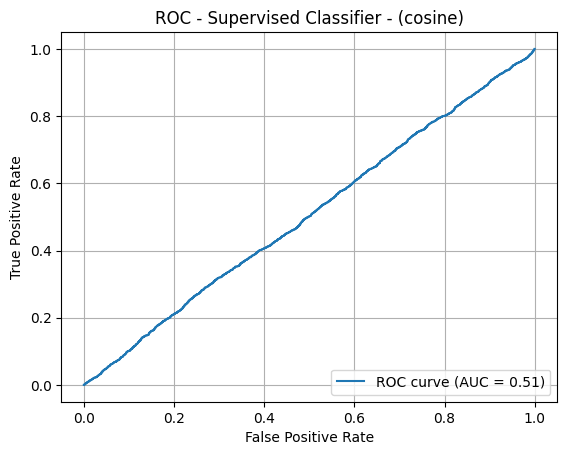

[THRESHOLD] Optimal threshold: 0.9985
[RESULT][Supervised Classifier] Verification Accuracy at optimal threshold (cosine): 0.5149
== SUMMARY ==
AUC Score: 0.5054
Verification Accuracy at Optimal Threshold: 0.5149


In [144]:
# Evaluate Supervised Classifier with Cosine
print("== Evaluate Supervised Classifier with Cosine ==")
roc_auc, accuracy = threshold_verification(
    model=model_cls.base,
    pair_file=PAIR_TXT,
    base_dir=VERIFICATION_DATA,
    transform=transform,
    device=device,
    metric="cosine",
    model_name="Supervised Classifier"
)

print(f"== SUMMARY ==")
print(f"AUC Score: {roc_auc:.4f}")
print(f"Verification Accuracy at Optimal Threshold: {accuracy:.4f}")

#### ii. Euclidean

Streaming output truncated to the last 5000 lines.
[INFO][Supervised Classifier|euclidean] Similarity score: -0.0401
[READ:6331] Pair: verification_data/00046783.jpg vs verification_data/00029390.jpg, Label: 0
[INFO][Supervised Classifier|euclidean] Similarity score: -0.1700
[READ:6332] Pair: verification_data/00041961.jpg vs verification_data/00010072.jpg, Label: 0
[INFO][Supervised Classifier|euclidean] Similarity score: -0.0967
[READ:6333] Pair: verification_data/00034864.jpg vs verification_data/00020409.jpg, Label: 1
[INFO][Supervised Classifier|euclidean] Similarity score: -0.0889
[READ:6334] Pair: verification_data/00002921.jpg vs verification_data/00065407.jpg, Label: 0
[INFO][Supervised Classifier|euclidean] Similarity score: -0.0582
[READ:6335] Pair: verification_data/00030601.jpg vs verification_data/00060317.jpg, Label: 1
[INFO][Supervised Classifier|euclidean] Similarity score: -0.1007
[READ:6336] Pair: verification_data/00012532.jpg vs verification_data/00002190.jpg, Labe

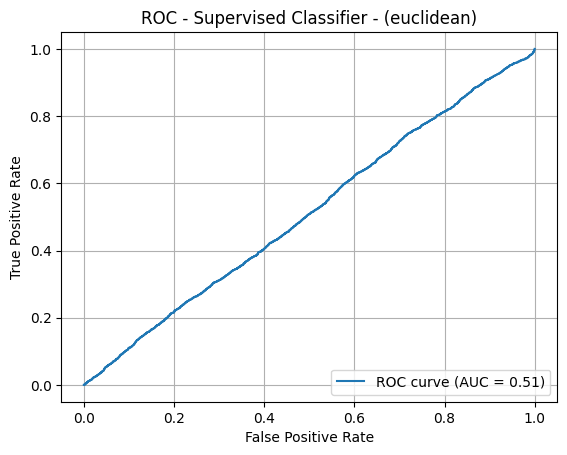

[THRESHOLD] Optimal threshold: -0.0975
[RESULT][Supervised Classifier] Verification Accuracy at optimal threshold (euclidean): 0.4901
== SUMMARY ==
AUC Score: 0.5114
Verification Accuracy at Optimal Threshold: 0.4901


In [145]:
# Evaluate Supervised Classifier with Euclidean
print("== Evaluate Supervised Classifier with Euclidean ==")
roc_auc, accuracy = threshold_verification(
    model=model_cls.base,
    pair_file=PAIR_TXT,
    base_dir=VERIFICATION_DATA,
    transform=transform,
    device=device,
    metric="euclidean",
    model_name="Supervised Classifier"
)

print(f"== SUMMARY ==")
print(f"AUC Score: {roc_auc:.4f}")
print(f"Verification Accuracy at Optimal Threshold: {accuracy:.4f}")

### 9b. Run Evaluation on Triplet Embedding

#### i. Cosine

Streaming output truncated to the last 5000 lines.
[INFO][Triplet Embedding|cosine] Similarity score: 0.9988
[READ:6331] Pair: verification_data/00046783.jpg vs verification_data/00029390.jpg, Label: 0
[INFO][Triplet Embedding|cosine] Similarity score: 0.9824
[READ:6332] Pair: verification_data/00041961.jpg vs verification_data/00010072.jpg, Label: 0
[INFO][Triplet Embedding|cosine] Similarity score: 0.9943
[READ:6333] Pair: verification_data/00034864.jpg vs verification_data/00020409.jpg, Label: 1
[INFO][Triplet Embedding|cosine] Similarity score: 0.9947
[READ:6334] Pair: verification_data/00002921.jpg vs verification_data/00065407.jpg, Label: 0
[INFO][Triplet Embedding|cosine] Similarity score: 0.9932
[READ:6335] Pair: verification_data/00030601.jpg vs verification_data/00060317.jpg, Label: 1
[INFO][Triplet Embedding|cosine] Similarity score: 0.9935
[READ:6336] Pair: verification_data/00012532.jpg vs verification_data/00002190.jpg, Label: 1
[INFO][Triplet Embedding|cosine] Similarity

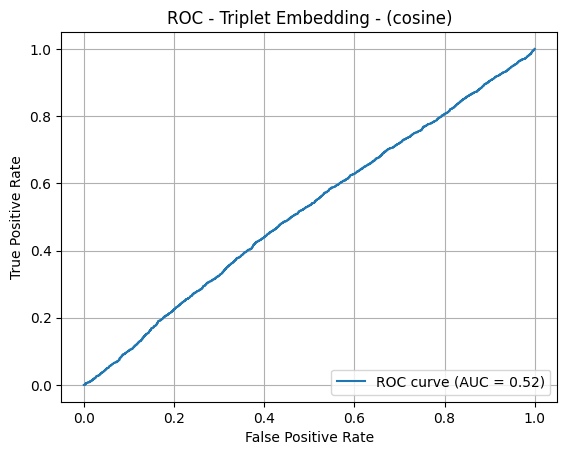

[THRESHOLD] Optimal threshold: 0.9981
[RESULT][Triplet Embedding] Verification Accuracy at optimal threshold (cosine): 0.5233
== SUMMARY ==
AUC Score: 0.5188
Verification Accuracy at Optimal Threshold: 0.5233


In [146]:
# Evaluate Triplet Embedding with Cosine
print("== Evaluate Triplet Embedding with Cosine ==")
roc_auc, accuracy = threshold_verification(
    model=model_triplet,
    pair_file=PAIR_TXT,
    base_dir=VERIFICATION_DATA,
    transform=transform,
    device=device,
    metric="cosine",
    model_name="Triplet Embedding"
)

print(f"== SUMMARY ==")
print(f"AUC Score: {roc_auc:.4f}")
print(f"Verification Accuracy at Optimal Threshold: {accuracy:.4f}")


#### ii. Euclidean

Streaming output truncated to the last 5000 lines.
[INFO][Triplet Embedding|euclidean] Similarity score: -0.0334
[READ:6331] Pair: verification_data/00046783.jpg vs verification_data/00029390.jpg, Label: 0
[INFO][Triplet Embedding|euclidean] Similarity score: -0.1309
[READ:6332] Pair: verification_data/00041961.jpg vs verification_data/00010072.jpg, Label: 0
[INFO][Triplet Embedding|euclidean] Similarity score: -0.0753
[READ:6333] Pair: verification_data/00034864.jpg vs verification_data/00020409.jpg, Label: 1
[INFO][Triplet Embedding|euclidean] Similarity score: -0.0679
[READ:6334] Pair: verification_data/00002921.jpg vs verification_data/00065407.jpg, Label: 0
[INFO][Triplet Embedding|euclidean] Similarity score: -0.0761
[READ:6335] Pair: verification_data/00030601.jpg vs verification_data/00060317.jpg, Label: 1
[INFO][Triplet Embedding|euclidean] Similarity score: -0.0798
[READ:6336] Pair: verification_data/00012532.jpg vs verification_data/00002190.jpg, Label: 1
[INFO][Triplet Embe

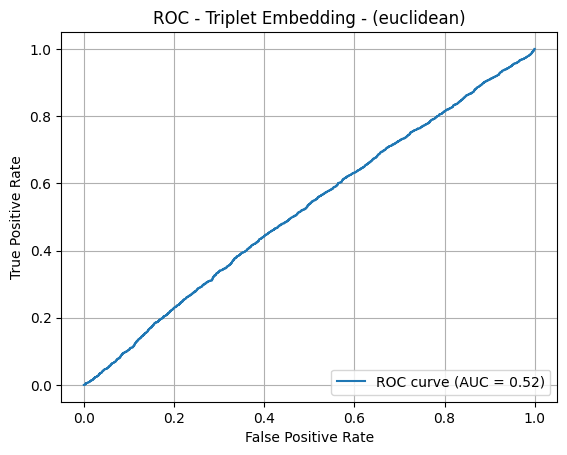

[THRESHOLD] Optimal threshold: -0.0429
[RESULT][Triplet Embedding] Verification Accuracy at optimal threshold (euclidean): 0.4762
== SUMMARY ==
AUC Score: 0.5226
Verification Accuracy at Optimal Threshold: 0.4762


In [147]:
# Evaluate Triplet Embedding with Euclidean
print("== Evaluate Triplet Embedding with Euclidean ==")
roc_auc, accuracy = threshold_verification(
    model=model_triplet,
    pair_file=PAIR_TXT,
    base_dir=VERIFICATION_DATA,
    transform=transform,
    device=device,
    metric="euclidean",
    model_name="Triplet Embedding"
)
print(f"== SUMMARY ==")
print(f"AUC Score: {roc_auc:.4f}")
print(f"Verification Accuracy at Optimal Threshold: {accuracy:.4f}")

### 9c. Compare Results

#### Threshold-Based Evaluation: ROC-AUC and Accuracy

##### Overview

In addition to ROC-AUC analysis (Step 6), we further evaluated model performance using a threshold-based decision mechanism to simulate a real-world verification system — where a similarity score between two faces must be **accepted** or **rejected** based on a fixed threshold.

The following script was used to:

* Compute ROC and AUC
* Determine the **optimal threshold** using **Youden's J statistic** (i.e., maximizing TPR - FPR)
* Evaluate final **verification accuracy** at that threshold

---

##### Evaluation Summary

| Model Type            | Distance Metric | AUC Score | Accuracy - Optimal Threshold |
| --------------------- | --------------- | --------- | ---------------------------- |
| Supervised Classifier | Cosine          | 0.5054    | 0.5149                       |
| Supervised Classifier | Euclidean       | 0.5114    | 0.4901                       |
| Triplet Embedding     | Cosine          | 0.5188    | 0.5233                       |
| Triplet Embedding     | Euclidean       | 0.5226    | 0.4762                       |

---

##### Insights & Interpretation

* **AUC scores are all near 0.5**, indicating **random guessing performance** for all four settings.
* **Verification accuracy** is similarly clustered around 50%, indicating the models **struggle to reliably separate same vs. different identities** based on embedding similarity.
* **Triplet embedding with cosine** performed **marginally best**, but the gap is minimal and not statistically significant.

---

##### Why the Performance May Be Low

1. **Undertrained Models**: If classification and metric learning models were trained for few epochs or with limited data, the embeddings might not have learned strong facial representations.

2. **Low Image Resolution or Quality**: Preprocessing inconsistencies or poor input quality can lead to noisy embeddings.

3. **Dataset Challenge**: The verification pairs may include highly similar negatives or challenging lighting/pose variations, making it harder for shallow models to distinguish.

4. **Metric Learning Limitations**: Triplet loss requires **careful mining** (e.g., hard or semi-hard negatives). Random triplets may not provide strong gradients for learning.

---

##### Takeaways

* **Threshold-based evaluation complements AUC** by simulating a deployable decision system.
* However, **AUC > 0.8** is typically required for face verification systems to be considered practically useful.
* These results suggest a need to:

  * Improve CNN architecture (e.g., deeper layers or pretrained backbones like MobileFaceNet)
  * Use smarter sampling strategies for triplet loss
  * Tune hyperparameters (e.g., margin, learning rate, batch size)